In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images/'

train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']

exclude_labels = (8,9,10)

In [4]:
from torchaffectnet.datasets import AffectNetDatasetForSupCon
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomApply,
                                    ColorJitter,
                                    RandomGrayscale,
                                    ToTensor)

class AffectNetDatasetForSupConWithValence(AffectNetDatasetForSupCon):
    def labeling(self, idx):
        target = torch.tensor(self.df['valence'][idx])
        if target < -0.5:
            return torch.tensor(0)
        elif target > 0.5:
            return torch.tensor(2)
        else:
            return torch.tensor(1)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

supcon_transform = Compose([
    RandomResizedCrop(size=tuple(feature_extractor.size.values()), scale=(0.2, 1.)),
    RandomHorizontalFlip(),
    RandomApply([
        ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    RandomGrayscale(p=0.2),
    ToTensor(),
    normalize
])

contrastive_dataset = AffectNetDatasetForSupConWithValence('../Affectnet/training.csv',
                                                           images_root,
                                                           transform=supcon_transform,
                                                           exclude_label=exclude_labels,
                                                           invalid_files=train_invalid_files)

len(contrastive_dataset)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs

287651

In [5]:
from torch.utils.data import DataLoader
from torchaffectnet.collators import ContrastiveCollator

train_dataloader = DataLoader(contrastive_dataset, collate_fn=ContrastiveCollator(return_labels=True), batch_size=16)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    if k == 'labels':
      print(k, v)
    else:
      print(k, v.shape)

pixel_values torch.Size([32, 3, 224, 224])
labels tensor([2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2])


In [6]:
from transformers import Trainer

from SupContrast.losses import SupConLoss

class SupConTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = SupConLoss()
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        bsz = labels.shape[0]
        outputs = model(pixel_values=inputs.get('pixel_values'), output_hidden_states=True)
        features = outputs.get('logits')
        f1, f2 = torch.split(features, [bsz, bsz])
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        loss = self.loss_fct(features, labels)
        return (loss, features) if return_outputs else loss

In [7]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(model_ckpt,
                                                  num_labels=64,
                                                  problem_type='regression')

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', group='affectnet-contrastive', name='exnone-valencelabel-SupCon-pretrain')

contrastive_args = TrainingArguments(
    f"affectnet-valence-supcon-exnone",
    save_strategy='epoch',
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=1e-3,
    logging_dir='contrastive-logs',
    logging_strategy='steps',
    logging_steps=1000,
    remove_unused_columns=False,
    report_to='wandb'
)

trainer = SupConTrainer(
    model,
    contrastive_args,
    train_dataset=contrastive_dataset,
    data_collator=ContrastiveCollator(return_labels=True),
    tokenizer=feature_extractor,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [9]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  1%|          | 1000/179790 [13:41<40:29:07,  1.23it/s]

{'loss': 3.321, 'learning_rate': 9.944379553924023e-05, 'epoch': 0.06}


  1%|          | 2000/179790 [27:19<40:09:12,  1.23it/s]

{'loss': 3.2828, 'learning_rate': 9.888759107848046e-05, 'epoch': 0.11}


  2%|▏         | 3000/179790 [40:55<40:38:54,  1.21it/s]

{'loss': 3.2796, 'learning_rate': 9.833138661772067e-05, 'epoch': 0.17}


  2%|▏         | 4000/179790 [54:17<39:05:39,  1.25it/s]

{'loss': 3.2688, 'learning_rate': 9.777518215696089e-05, 'epoch': 0.22}


  3%|▎         | 5000/179790 [1:10:19<47:01:02,  1.03it/s] 

{'loss': 3.2664, 'learning_rate': 9.721897769620113e-05, 'epoch': 0.28}


  3%|▎         | 6000/179790 [1:28:52<51:51:54,  1.07s/it] 

{'loss': 3.257, 'learning_rate': 9.666277323544135e-05, 'epoch': 0.33}


  4%|▍         | 7000/179790 [1:45:39<66:42:25,  1.39s/it] 

{'loss': 3.2545, 'learning_rate': 9.610656877468159e-05, 'epoch': 0.39}


  4%|▍         | 8000/179790 [2:01:49<47:51:16,  1.00s/it] 

{'loss': 3.2518, 'learning_rate': 9.555036431392181e-05, 'epoch': 0.44}


  5%|▌         | 9000/179790 [2:18:11<52:04:39,  1.10s/it]

{'loss': 3.2545, 'learning_rate': 9.499415985316202e-05, 'epoch': 0.5}


  6%|▌         | 10000/179790 [2:34:38<46:20:11,  1.02it/s]

{'loss': 3.2507, 'learning_rate': 9.443795539240225e-05, 'epoch': 0.56}


  6%|▌         | 11000/179790 [2:50:47<48:02:12,  1.02s/it]

{'loss': 3.2423, 'learning_rate': 9.388175093164247e-05, 'epoch': 0.61}


  7%|▋         | 12000/179790 [3:06:32<38:09:59,  1.22it/s] 

{'loss': 3.2459, 'learning_rate': 9.33255464708827e-05, 'epoch': 0.67}


  7%|▋         | 13000/179790 [3:23:50<45:51:36,  1.01it/s] 

{'loss': 3.2398, 'learning_rate': 9.276934201012293e-05, 'epoch': 0.72}


  8%|▊         | 14000/179790 [3:40:51<49:04:16,  1.07s/it] 

{'loss': 3.2406, 'learning_rate': 9.221313754936315e-05, 'epoch': 0.78}


  8%|▊         | 15000/179790 [3:57:25<37:21:51,  1.23it/s] 

{'loss': 3.2482, 'learning_rate': 9.165693308860336e-05, 'epoch': 0.83}


  9%|▉         | 16000/179790 [4:13:05<36:23:44,  1.25it/s] 

{'loss': 3.2388, 'learning_rate': 9.11007286278436e-05, 'epoch': 0.89}


  9%|▉         | 17000/179790 [4:29:15<51:53:23,  1.15s/it] 

{'loss': 3.246, 'learning_rate': 9.054452416708382e-05, 'epoch': 0.95}


 10%|█         | 18000/179790 [4:47:35<33:18:31,  1.35it/s] 

{'loss': 3.2367, 'learning_rate': 8.998831970632406e-05, 'epoch': 1.0}


 11%|█         | 19000/179790 [5:01:01<37:16:10,  1.20it/s]

{'loss': 3.2354, 'learning_rate': 8.943211524556428e-05, 'epoch': 1.06}


 11%|█         | 20000/179790 [5:14:35<36:02:26,  1.23it/s]

{'loss': 3.2333, 'learning_rate': 8.88759107848045e-05, 'epoch': 1.11}


 12%|█▏        | 21000/179790 [5:28:11<35:50:40,  1.23it/s]

{'loss': 3.23, 'learning_rate': 8.831970632404472e-05, 'epoch': 1.17}


 12%|█▏        | 22000/179790 [5:42:09<41:32:57,  1.05it/s] 

{'loss': 3.2353, 'learning_rate': 8.776350186328494e-05, 'epoch': 1.22}


 13%|█▎        | 23000/179790 [5:56:11<39:22:19,  1.11it/s]

{'loss': 3.2221, 'learning_rate': 8.720729740252517e-05, 'epoch': 1.28}


 13%|█▎        | 24000/179790 [6:10:09<38:00:52,  1.14it/s]

{'loss': 3.2328, 'learning_rate': 8.66510929417654e-05, 'epoch': 1.33}


 14%|█▍        | 25000/179790 [6:23:45<41:23:35,  1.04it/s]

{'loss': 3.2357, 'learning_rate': 8.609488848100562e-05, 'epoch': 1.39}


 14%|█▍        | 26000/179790 [6:37:39<33:59:58,  1.26it/s]

{'loss': 3.2348, 'learning_rate': 8.553868402024585e-05, 'epoch': 1.45}


 15%|█▌        | 27000/179790 [6:51:17<36:51:56,  1.15it/s]

{'loss': 3.227, 'learning_rate': 8.498247955948607e-05, 'epoch': 1.5}


 16%|█▌        | 28000/179790 [7:05:01<34:34:02,  1.22it/s]

{'loss': 3.2298, 'learning_rate': 8.442627509872629e-05, 'epoch': 1.56}


 16%|█▌        | 29000/179790 [7:18:32<34:09:19,  1.23it/s]

{'loss': 3.2252, 'learning_rate': 8.387007063796653e-05, 'epoch': 1.61}


 17%|█▋        | 30000/179790 [7:32:02<32:52:55,  1.27it/s]

{'loss': 3.2128, 'learning_rate': 8.331386617720675e-05, 'epoch': 1.67}


 17%|█▋        | 31000/179790 [7:45:39<31:54:40,  1.30it/s]

{'loss': 3.2252, 'learning_rate': 8.275766171644697e-05, 'epoch': 1.72}


 18%|█▊        | 32000/179790 [7:59:25<41:40:52,  1.02s/it]

{'loss': 3.2243, 'learning_rate': 8.220145725568719e-05, 'epoch': 1.78}


 18%|█▊        | 33000/179790 [8:13:00<35:27:30,  1.15it/s]

{'loss': 3.2271, 'learning_rate': 8.164525279492742e-05, 'epoch': 1.84}


 19%|█▉        | 34000/179790 [8:26:35<32:11:35,  1.26it/s]

{'loss': 3.2176, 'learning_rate': 8.108904833416764e-05, 'epoch': 1.89}


 19%|█▉        | 35000/179790 [8:40:11<33:05:42,  1.22it/s]

{'loss': 3.2243, 'learning_rate': 8.053284387340787e-05, 'epoch': 1.95}


 20%|██        | 36000/179790 [8:53:57<28:34:11,  1.40it/s]

{'loss': 3.2161, 'learning_rate': 7.99766394126481e-05, 'epoch': 2.0}


 21%|██        | 37000/179790 [9:07:11<31:33:00,  1.26it/s]

{'loss': 3.2171, 'learning_rate': 7.942043495188832e-05, 'epoch': 2.06}


 21%|██        | 38000/179790 [9:20:35<32:19:42,  1.22it/s]

{'loss': 3.2246, 'learning_rate': 7.886423049112854e-05, 'epoch': 2.11}


 22%|██▏       | 39000/179790 [9:34:05<31:56:58,  1.22it/s]

{'loss': 3.2186, 'learning_rate': 7.830802603036876e-05, 'epoch': 2.17}


 22%|██▏       | 40000/179790 [9:47:46<31:08:21,  1.25it/s]

{'loss': 3.2176, 'learning_rate': 7.7751821569609e-05, 'epoch': 2.22}


 23%|██▎       | 41000/179790 [10:01:26<31:04:16,  1.24it/s]

{'loss': 3.2133, 'learning_rate': 7.719561710884922e-05, 'epoch': 2.28}


 23%|██▎       | 42000/179790 [10:14:54<29:24:45,  1.30it/s]

{'loss': 3.2148, 'learning_rate': 7.663941264808944e-05, 'epoch': 2.34}


 24%|██▍       | 43000/179790 [10:28:23<31:03:14,  1.22it/s]

{'loss': 3.2161, 'learning_rate': 7.608320818732966e-05, 'epoch': 2.39}


 24%|██▍       | 44000/179790 [10:41:57<29:41:41,  1.27it/s]

{'loss': 3.2068, 'learning_rate': 7.552700372656989e-05, 'epoch': 2.45}


 25%|██▌       | 45000/179790 [10:55:44<30:32:36,  1.23it/s]

{'loss': 3.2101, 'learning_rate': 7.497079926581011e-05, 'epoch': 2.5}


 26%|██▌       | 46000/179790 [11:09:18<33:03:19,  1.12it/s]

{'loss': 3.2138, 'learning_rate': 7.441459480505034e-05, 'epoch': 2.56}


 26%|██▌       | 47000/179790 [11:22:48<30:14:38,  1.22it/s]

{'loss': 3.2119, 'learning_rate': 7.385839034429057e-05, 'epoch': 2.61}


 27%|██▋       | 48000/179790 [11:36:15<31:22:27,  1.17it/s]

{'loss': 3.2151, 'learning_rate': 7.33021858835308e-05, 'epoch': 2.67}


 27%|██▋       | 49000/179790 [11:49:51<29:29:29,  1.23it/s]

{'loss': 3.2118, 'learning_rate': 7.274598142277101e-05, 'epoch': 2.73}


 28%|██▊       | 50000/179790 [12:03:26<31:48:48,  1.13it/s]

{'loss': 3.2085, 'learning_rate': 7.218977696201123e-05, 'epoch': 2.78}


 28%|██▊       | 51000/179790 [12:16:57<30:03:41,  1.19it/s]

{'loss': 3.2093, 'learning_rate': 7.163357250125147e-05, 'epoch': 2.84}


 29%|██▉       | 52000/179790 [12:30:31<31:02:33,  1.14it/s]

{'loss': 3.2106, 'learning_rate': 7.107736804049169e-05, 'epoch': 2.89}


 29%|██▉       | 53000/179790 [12:44:04<29:21:30,  1.20it/s]

{'loss': 3.2127, 'learning_rate': 7.052116357973191e-05, 'epoch': 2.95}


 30%|███       | 54000/179790 [12:57:43<28:44:38,  1.22it/s]

{'loss': 3.215, 'learning_rate': 6.996495911897213e-05, 'epoch': 3.0}


 31%|███       | 55000/179790 [13:11:22<27:32:49,  1.26it/s]

{'loss': 3.2045, 'learning_rate': 6.940875465821236e-05, 'epoch': 3.06}


 31%|███       | 56000/179790 [13:24:54<27:22:52,  1.26it/s]

{'loss': 3.2063, 'learning_rate': 6.885255019745259e-05, 'epoch': 3.11}


 32%|███▏      | 57000/179790 [13:38:27<25:27:28,  1.34it/s]

{'loss': 3.2085, 'learning_rate': 6.829634573669281e-05, 'epoch': 3.17}


 32%|███▏      | 58000/179790 [13:55:56<26:26:57,  1.28it/s] 

{'loss': 3.2084, 'learning_rate': 6.774014127593304e-05, 'epoch': 3.23}


 33%|███▎      | 59000/179790 [14:09:43<29:12:05,  1.15it/s]

{'loss': 3.2054, 'learning_rate': 6.718393681517327e-05, 'epoch': 3.28}


 33%|███▎      | 60000/179790 [14:23:18<28:07:35,  1.18it/s]

{'loss': 3.2059, 'learning_rate': 6.662773235441348e-05, 'epoch': 3.34}


 34%|███▍      | 61000/179790 [14:36:56<26:36:26,  1.24it/s]

{'loss': 3.2024, 'learning_rate': 6.60715278936537e-05, 'epoch': 3.39}


 34%|███▍      | 62000/179790 [14:50:35<25:39:59,  1.27it/s]

{'loss': 3.2094, 'learning_rate': 6.551532343289394e-05, 'epoch': 3.45}


 35%|███▌      | 63000/179790 [15:04:06<25:57:21,  1.25it/s]

{'loss': 3.2048, 'learning_rate': 6.495911897213416e-05, 'epoch': 3.5}


 36%|███▌      | 64000/179790 [15:17:45<25:35:27,  1.26it/s]

{'loss': 3.1987, 'learning_rate': 6.440291451137438e-05, 'epoch': 3.56}


 36%|███▌      | 65000/179790 [15:31:17<27:12:12,  1.17it/s]

{'loss': 3.206, 'learning_rate': 6.384671005061462e-05, 'epoch': 3.62}


 37%|███▋      | 66000/179790 [15:44:56<24:36:49,  1.28it/s]

{'loss': 3.2101, 'learning_rate': 6.329050558985483e-05, 'epoch': 3.67}


 37%|███▋      | 67000/179790 [15:58:26<25:08:42,  1.25it/s]

{'loss': 3.2043, 'learning_rate': 6.273430112909506e-05, 'epoch': 3.73}


 38%|███▊      | 68000/179790 [16:11:59<23:44:05,  1.31it/s]

{'loss': 3.2063, 'learning_rate': 6.217809666833528e-05, 'epoch': 3.78}


 38%|███▊      | 69000/179790 [16:25:36<24:37:41,  1.25it/s]

{'loss': 3.1981, 'learning_rate': 6.16218922075755e-05, 'epoch': 3.84}


 39%|███▉      | 70000/179790 [16:39:21<25:50:14,  1.18it/s]

{'loss': 3.2033, 'learning_rate': 6.106568774681574e-05, 'epoch': 3.89}


 39%|███▉      | 71000/179790 [16:53:00<25:27:28,  1.19it/s]

{'loss': 3.2025, 'learning_rate': 6.0509483286055956e-05, 'epoch': 3.95}


 40%|████      | 72000/179790 [17:07:20<22:57:57,  1.30it/s]

{'loss': 3.1939, 'learning_rate': 5.995327882529618e-05, 'epoch': 4.0}


 41%|████      | 73000/179790 [17:20:47<22:53:49,  1.30it/s]

{'loss': 3.1923, 'learning_rate': 5.939707436453641e-05, 'epoch': 4.06}


 41%|████      | 74000/179790 [17:34:25<23:41:15,  1.24it/s]

{'loss': 3.199, 'learning_rate': 5.884086990377663e-05, 'epoch': 4.12}


 42%|████▏     | 75000/179790 [17:47:55<24:24:30,  1.19it/s]

{'loss': 3.2022, 'learning_rate': 5.828466544301685e-05, 'epoch': 4.17}


 42%|████▏     | 76000/179790 [18:01:39<24:13:03,  1.19it/s]

{'loss': 3.1959, 'learning_rate': 5.772846098225708e-05, 'epoch': 4.23}


 43%|████▎     | 77000/179790 [18:15:28<23:51:57,  1.20it/s]

{'loss': 3.1944, 'learning_rate': 5.71722565214973e-05, 'epoch': 4.28}


 43%|████▎     | 78000/179790 [18:29:07<24:14:57,  1.17it/s]

{'loss': 3.2014, 'learning_rate': 5.661605206073753e-05, 'epoch': 4.34}


 44%|████▍     | 79000/179790 [18:42:10<20:59:04,  1.33it/s]

{'loss': 3.1992, 'learning_rate': 5.605984759997775e-05, 'epoch': 4.39}


 44%|████▍     | 80000/179790 [18:55:17<23:37:54,  1.17it/s]

{'loss': 3.2028, 'learning_rate': 5.5503643139217975e-05, 'epoch': 4.45}


 45%|████▌     | 81000/179790 [19:08:23<22:38:03,  1.21it/s]

{'loss': 3.1956, 'learning_rate': 5.4947438678458204e-05, 'epoch': 4.51}


 46%|████▌     | 82000/179790 [19:21:33<20:32:37,  1.32it/s]

{'loss': 3.1953, 'learning_rate': 5.4391234217698426e-05, 'epoch': 4.56}


 46%|████▌     | 83000/179790 [19:35:06<20:15:48,  1.33it/s]

{'loss': 3.1959, 'learning_rate': 5.383502975693865e-05, 'epoch': 4.62}


 47%|████▋     | 84000/179790 [19:48:47<20:12:32,  1.32it/s]

{'loss': 3.2041, 'learning_rate': 5.327882529617888e-05, 'epoch': 4.67}


 47%|████▋     | 85000/179790 [20:02:23<20:55:52,  1.26it/s]

{'loss': 3.1928, 'learning_rate': 5.27226208354191e-05, 'epoch': 4.73}


 48%|████▊     | 86000/179790 [20:16:00<23:31:56,  1.11it/s]

{'loss': 3.1948, 'learning_rate': 5.2166416374659335e-05, 'epoch': 4.78}


 48%|████▊     | 87000/179790 [20:29:30<27:01:58,  1.05s/it]

{'loss': 3.1941, 'learning_rate': 5.161021191389955e-05, 'epoch': 4.84}


 49%|████▉     | 88000/179790 [20:43:10<19:50:51,  1.28it/s]

{'loss': 3.1918, 'learning_rate': 5.105400745313977e-05, 'epoch': 4.89}


 50%|████▉     | 89000/179790 [20:56:51<20:25:32,  1.23it/s]

{'loss': 3.1973, 'learning_rate': 5.049780299238001e-05, 'epoch': 4.95}


 50%|█████     | 90000/179790 [21:10:35<20:06:22,  1.24it/s]

{'loss': 3.1951, 'learning_rate': 4.994159853162022e-05, 'epoch': 5.01}


 51%|█████     | 91000/179790 [21:23:52<19:51:23,  1.24it/s]

{'loss': 3.1749, 'learning_rate': 4.938539407086045e-05, 'epoch': 5.06}


 51%|█████     | 92000/179790 [21:37:35<20:00:35,  1.22it/s]

{'loss': 3.1887, 'learning_rate': 4.8829189610100674e-05, 'epoch': 5.12}


 52%|█████▏    | 93000/179790 [21:51:08<21:31:25,  1.12it/s]

{'loss': 3.1988, 'learning_rate': 4.8272985149340896e-05, 'epoch': 5.17}


 52%|█████▏    | 94000/179790 [22:04:56<19:47:47,  1.20it/s]

{'loss': 3.1885, 'learning_rate': 4.7716780688581125e-05, 'epoch': 5.23}


 53%|█████▎    | 95000/179790 [22:18:36<18:56:09,  1.24it/s]

{'loss': 3.1982, 'learning_rate': 4.7160576227821354e-05, 'epoch': 5.28}


 53%|█████▎    | 96000/179790 [22:32:07<19:42:59,  1.18it/s]

{'loss': 3.1904, 'learning_rate': 4.660437176706157e-05, 'epoch': 5.34}


 54%|█████▍    | 97000/179790 [22:45:51<18:53:00,  1.22it/s]

{'loss': 3.1818, 'learning_rate': 4.60481673063018e-05, 'epoch': 5.4}


 55%|█████▍    | 98000/179790 [22:59:37<20:47:34,  1.09it/s]

{'loss': 3.1913, 'learning_rate': 4.549196284554203e-05, 'epoch': 5.45}


 55%|█████▌    | 99000/179790 [23:13:34<19:02:03,  1.18it/s]

{'loss': 3.1944, 'learning_rate': 4.493575838478225e-05, 'epoch': 5.51}


 56%|█████▌    | 100000/179790 [23:27:25<17:35:58,  1.26it/s]

{'loss': 3.1843, 'learning_rate': 4.437955392402247e-05, 'epoch': 5.56}


 56%|█████▌    | 101000/179790 [23:41:21<16:59:15,  1.29it/s]

{'loss': 3.1902, 'learning_rate': 4.38233494632627e-05, 'epoch': 5.62}


 57%|█████▋    | 102000/179790 [23:55:36<17:44:13,  1.22it/s]

{'loss': 3.1892, 'learning_rate': 4.326714500250292e-05, 'epoch': 5.67}


 57%|█████▋    | 103000/179790 [24:10:46<18:48:24,  1.13it/s]

{'loss': 3.1809, 'learning_rate': 4.2710940541743144e-05, 'epoch': 5.73}


 58%|█████▊    | 104000/179790 [24:25:40<17:04:36,  1.23it/s]

{'loss': 3.1895, 'learning_rate': 4.215473608098337e-05, 'epoch': 5.78}


 58%|█████▊    | 105000/179790 [24:40:17<16:53:28,  1.23it/s]

{'loss': 3.1861, 'learning_rate': 4.1598531620223595e-05, 'epoch': 5.84}


 59%|█████▉    | 106000/179790 [24:54:50<16:19:21,  1.26it/s]

{'loss': 3.1879, 'learning_rate': 4.1042327159463824e-05, 'epoch': 5.9}


 60%|█████▉    | 107000/179790 [25:09:11<15:46:52,  1.28it/s]

{'loss': 3.1902, 'learning_rate': 4.0486122698704046e-05, 'epoch': 5.95}


 60%|██████    | 108000/179790 [25:23:45<15:53:03,  1.26it/s]

{'loss': 3.1838, 'learning_rate': 3.992991823794427e-05, 'epoch': 6.01}


 61%|██████    | 109000/179790 [25:37:48<15:46:30,  1.25it/s]

{'loss': 3.1799, 'learning_rate': 3.93737137771845e-05, 'epoch': 6.06}


 61%|██████    | 110000/179790 [25:52:20<16:38:15,  1.17it/s]

{'loss': 3.184, 'learning_rate': 3.881750931642472e-05, 'epoch': 6.12}


 62%|██████▏   | 111000/179790 [26:07:36<16:04:56,  1.19it/s]

{'loss': 3.1758, 'learning_rate': 3.826130485566494e-05, 'epoch': 6.17}


 62%|██████▏   | 112000/179790 [26:22:48<16:29:16,  1.14it/s]

{'loss': 3.1755, 'learning_rate': 3.770510039490517e-05, 'epoch': 6.23}


 63%|██████▎   | 113000/179790 [26:37:50<15:53:56,  1.17it/s]

{'loss': 3.1896, 'learning_rate': 3.714889593414539e-05, 'epoch': 6.29}


 63%|██████▎   | 114000/179790 [26:53:07<17:33:04,  1.04it/s]

{'loss': 3.1838, 'learning_rate': 3.659269147338562e-05, 'epoch': 6.34}


 64%|██████▍   | 115000/179790 [27:08:27<15:02:45,  1.20it/s]

{'loss': 3.1773, 'learning_rate': 3.603648701262584e-05, 'epoch': 6.4}


 65%|██████▍   | 116000/179790 [27:23:59<17:01:03,  1.04it/s]

{'loss': 3.1773, 'learning_rate': 3.5480282551866065e-05, 'epoch': 6.45}


 65%|██████▌   | 117000/179790 [27:39:41<15:30:33,  1.12it/s]

{'loss': 3.1748, 'learning_rate': 3.4924078091106294e-05, 'epoch': 6.51}


 66%|██████▌   | 118000/179790 [27:55:28<16:56:06,  1.01it/s]

{'loss': 3.1829, 'learning_rate': 3.4367873630346516e-05, 'epoch': 6.56}


 66%|██████▌   | 119000/179790 [28:11:33<18:00:49,  1.07s/it]

{'loss': 3.1755, 'learning_rate': 3.381166916958674e-05, 'epoch': 6.62}


 67%|██████▋   | 120000/179790 [28:28:03<17:20:00,  1.04s/it]

{'loss': 3.1841, 'learning_rate': 3.325546470882697e-05, 'epoch': 6.67}


 67%|██████▋   | 121000/179790 [28:49:14<12:47:48,  1.28it/s]

{'loss': 3.1752, 'learning_rate': 3.269926024806719e-05, 'epoch': 6.73}


 68%|██████▊   | 122000/179790 [29:11:11<15:20:01,  1.05it/s] 

{'loss': 3.1742, 'learning_rate': 3.214305578730741e-05, 'epoch': 6.79}


 68%|██████▊   | 123000/179790 [29:33:49<18:37:34,  1.18s/it] 

{'loss': 3.1745, 'learning_rate': 3.158685132654764e-05, 'epoch': 6.84}


 69%|██████▉   | 124000/179790 [29:51:51<16:16:40,  1.05s/it]

{'loss': 3.1822, 'learning_rate': 3.103064686578786e-05, 'epoch': 6.9}


 70%|██████▉   | 125000/179790 [30:08:46<17:29:27,  1.15s/it]

{'loss': 3.1841, 'learning_rate': 3.047444240502809e-05, 'epoch': 6.95}


 70%|███████   | 126000/179790 [30:25:18<12:26:06,  1.20it/s]

{'loss': 3.172, 'learning_rate': 2.9918237944268313e-05, 'epoch': 7.01}


 71%|███████   | 127000/179790 [30:40:08<11:27:32,  1.28it/s]

{'loss': 3.1714, 'learning_rate': 2.936203348350854e-05, 'epoch': 7.06}


 71%|███████   | 128000/179790 [30:55:05<11:30:07,  1.25it/s]

{'loss': 3.1695, 'learning_rate': 2.8805829022748764e-05, 'epoch': 7.12}


 72%|███████▏  | 129000/179790 [31:10:04<14:27:14,  1.02s/it]

{'loss': 3.1725, 'learning_rate': 2.824962456198899e-05, 'epoch': 7.18}


 72%|███████▏  | 130000/179790 [31:24:49<13:33:13,  1.02it/s]

{'loss': 3.1755, 'learning_rate': 2.7693420101229212e-05, 'epoch': 7.23}


 73%|███████▎  | 131000/179790 [31:39:25<10:37:15,  1.28it/s]

{'loss': 3.1693, 'learning_rate': 2.7137215640469437e-05, 'epoch': 7.29}


 73%|███████▎  | 132000/179790 [31:54:02<10:59:30,  1.21it/s]

{'loss': 3.1729, 'learning_rate': 2.6581011179709663e-05, 'epoch': 7.34}


 74%|███████▍  | 133000/179790 [32:08:49<13:21:26,  1.03s/it]

{'loss': 3.1733, 'learning_rate': 2.6024806718949885e-05, 'epoch': 7.4}


 75%|███████▍  | 134000/179790 [32:24:22<10:26:01,  1.22it/s]

{'loss': 3.1674, 'learning_rate': 2.546860225819011e-05, 'epoch': 7.45}


 75%|███████▌  | 135000/179790 [32:39:34<11:53:23,  1.05it/s]

{'loss': 3.17, 'learning_rate': 2.4912397797430336e-05, 'epoch': 7.51}


 76%|███████▌  | 136000/179790 [32:54:35<16:08:06,  1.33s/it]

{'loss': 3.1745, 'learning_rate': 2.435619333667056e-05, 'epoch': 7.56}


 76%|███████▌  | 137000/179790 [33:09:52<11:08:01,  1.07it/s]

{'loss': 3.1741, 'learning_rate': 2.3799988875910787e-05, 'epoch': 7.62}


 77%|███████▋  | 138000/179790 [33:24:38<10:05:11,  1.15it/s]

{'loss': 3.1776, 'learning_rate': 2.324378441515101e-05, 'epoch': 7.68}


 77%|███████▋  | 139000/179790 [33:39:15<10:07:29,  1.12it/s]

{'loss': 3.1667, 'learning_rate': 2.2687579954391235e-05, 'epoch': 7.73}


 78%|███████▊  | 140000/179790 [33:53:55<9:11:30,  1.20it/s] 

{'loss': 3.1677, 'learning_rate': 2.213137549363146e-05, 'epoch': 7.79}


 78%|███████▊  | 141000/179790 [34:08:48<9:06:15,  1.18it/s] 

{'loss': 3.1689, 'learning_rate': 2.1575171032871685e-05, 'epoch': 7.84}


 79%|███████▉  | 142000/179790 [34:23:49<11:45:23,  1.12s/it]

{'loss': 3.1664, 'learning_rate': 2.1018966572111908e-05, 'epoch': 7.9}


 80%|███████▉  | 143000/179790 [34:38:33<8:55:41,  1.14it/s] 

{'loss': 3.172, 'learning_rate': 2.0462762111352136e-05, 'epoch': 7.95}


 80%|████████  | 144000/179790 [34:53:14<7:51:59,  1.26it/s] 

{'loss': 3.1725, 'learning_rate': 1.990655765059236e-05, 'epoch': 8.01}


 81%|████████  | 145000/179790 [35:06:37<8:28:42,  1.14it/s] 

{'loss': 3.1677, 'learning_rate': 1.9350353189832584e-05, 'epoch': 8.06}


 81%|████████  | 146000/179790 [35:20:19<7:48:34,  1.20it/s] 

{'loss': 3.1597, 'learning_rate': 1.879414872907281e-05, 'epoch': 8.12}


 82%|████████▏ | 147000/179790 [35:34:01<7:18:12,  1.25it/s]

{'loss': 3.1527, 'learning_rate': 1.823794426831303e-05, 'epoch': 8.18}


 82%|████████▏ | 148000/179790 [35:47:46<7:36:30,  1.16it/s]

{'loss': 3.1703, 'learning_rate': 1.7681739807553257e-05, 'epoch': 8.23}


 83%|████████▎ | 149000/179790 [36:01:32<6:45:28,  1.27it/s] 

{'loss': 3.1642, 'learning_rate': 1.7125535346793483e-05, 'epoch': 8.29}


 83%|████████▎ | 150000/179790 [36:15:10<6:43:43,  1.23it/s]

{'loss': 3.1593, 'learning_rate': 1.6569330886033708e-05, 'epoch': 8.34}


 84%|████████▍ | 151000/179790 [36:28:48<6:41:18,  1.20it/s]

{'loss': 3.1628, 'learning_rate': 1.601312642527393e-05, 'epoch': 8.4}


 85%|████████▍ | 152000/179790 [36:42:21<6:38:18,  1.16it/s]

{'loss': 3.1719, 'learning_rate': 1.5456921964514156e-05, 'epoch': 8.45}


 85%|████████▌ | 153000/179790 [36:55:56<6:16:43,  1.19it/s]

{'loss': 3.1618, 'learning_rate': 1.490071750375438e-05, 'epoch': 8.51}


 86%|████████▌ | 154000/179790 [37:09:55<5:43:14,  1.25it/s] 

{'loss': 3.1601, 'learning_rate': 1.4344513042994607e-05, 'epoch': 8.57}


 86%|████████▌ | 155000/179790 [37:23:31<5:32:13,  1.24it/s]

{'loss': 3.1533, 'learning_rate': 1.378830858223483e-05, 'epoch': 8.62}


 87%|████████▋ | 156000/179790 [37:37:06<5:31:39,  1.20it/s]

{'loss': 3.1648, 'learning_rate': 1.3232104121475056e-05, 'epoch': 8.68}


 87%|████████▋ | 157000/179790 [37:50:41<5:15:56,  1.20it/s]

{'loss': 3.1684, 'learning_rate': 1.267589966071528e-05, 'epoch': 8.73}


 88%|████████▊ | 158000/179790 [38:04:34<6:34:34,  1.09s/it]

{'loss': 3.1568, 'learning_rate': 1.2119695199955503e-05, 'epoch': 8.79}


 88%|████████▊ | 159000/179790 [38:18:22<4:34:08,  1.26it/s]

{'loss': 3.1597, 'learning_rate': 1.1563490739195729e-05, 'epoch': 8.84}


 89%|████████▉ | 160000/179790 [38:31:57<4:21:56,  1.26it/s]

{'loss': 3.1662, 'learning_rate': 1.1007286278435953e-05, 'epoch': 8.9}


 90%|████████▉ | 161000/179790 [38:45:40<4:06:18,  1.27it/s]

{'loss': 3.153, 'learning_rate': 1.0451081817676178e-05, 'epoch': 8.95}


 90%|█████████ | 162000/179790 [38:59:24<3:51:54,  1.28it/s]

{'loss': 3.1629, 'learning_rate': 9.894877356916404e-06, 'epoch': 9.01}


 91%|█████████ | 163000/179790 [39:12:47<3:34:18,  1.31it/s]

{'loss': 3.1608, 'learning_rate': 9.338672896156627e-06, 'epoch': 9.07}


 91%|█████████ | 164000/179790 [39:26:25<3:42:03,  1.19it/s]

{'loss': 3.142, 'learning_rate': 8.782468435396853e-06, 'epoch': 9.12}


 92%|█████████▏| 165000/179790 [39:40:03<3:20:34,  1.23it/s]

{'loss': 3.1517, 'learning_rate': 8.226263974637077e-06, 'epoch': 9.18}


 92%|█████████▏| 166000/179790 [39:53:56<3:14:25,  1.18it/s]

{'loss': 3.1599, 'learning_rate': 7.670059513877302e-06, 'epoch': 9.23}


 93%|█████████▎| 167000/179790 [40:07:37<2:47:35,  1.27it/s]

{'loss': 3.1589, 'learning_rate': 7.113855053117527e-06, 'epoch': 9.29}


 93%|█████████▎| 168000/179790 [40:21:13<2:41:54,  1.21it/s]

{'loss': 3.1479, 'learning_rate': 6.557650592357751e-06, 'epoch': 9.34}


 94%|█████████▍| 169000/179790 [40:34:51<2:16:05,  1.32it/s]

{'loss': 3.1539, 'learning_rate': 6.001446131597976e-06, 'epoch': 9.4}


 95%|█████████▍| 170000/179790 [40:48:39<2:10:35,  1.25it/s]

{'loss': 3.1602, 'learning_rate': 5.445241670838201e-06, 'epoch': 9.46}


 95%|█████████▌| 171000/179790 [41:02:24<1:54:06,  1.28it/s]

{'loss': 3.1546, 'learning_rate': 4.889037210078425e-06, 'epoch': 9.51}


 96%|█████████▌| 172000/179790 [41:15:58<1:52:55,  1.15it/s]

{'loss': 3.1521, 'learning_rate': 4.33283274931865e-06, 'epoch': 9.57}


 96%|█████████▌| 173000/179790 [41:29:32<1:36:53,  1.17it/s]

{'loss': 3.1459, 'learning_rate': 3.776628288558874e-06, 'epoch': 9.62}


 97%|█████████▋| 174000/179790 [41:43:10<1:17:14,  1.25it/s]

{'loss': 3.1496, 'learning_rate': 3.2204238277990988e-06, 'epoch': 9.68}


 97%|█████████▋| 175000/179790 [41:56:46<1:02:09,  1.28it/s]

{'loss': 3.1447, 'learning_rate': 2.664219367039324e-06, 'epoch': 9.73}


 98%|█████████▊| 176000/179790 [42:10:26<50:30,  1.25it/s]  

{'loss': 3.1509, 'learning_rate': 2.1080149062795485e-06, 'epoch': 9.79}


 98%|█████████▊| 177000/179790 [42:24:11<37:49,  1.23it/s]  

{'loss': 3.1441, 'learning_rate': 1.5518104455197733e-06, 'epoch': 9.84}


 99%|█████████▉| 178000/179790 [42:37:48<26:14,  1.14it/s]

{'loss': 3.1529, 'learning_rate': 9.95605984759998e-07, 'epoch': 9.9}


100%|█████████▉| 179000/179790 [42:51:23<10:31,  1.25it/s]

{'loss': 3.1592, 'learning_rate': 4.394015240002225e-07, 'epoch': 9.96}


100%|██████████| 179790/179790 [43:02:09<00:00,  1.16it/s]


{'train_runtime': 154929.8457, 'train_samples_per_second': 18.567, 'train_steps_per_second': 1.16, 'train_loss': 3.1952238779987243, 'epoch': 10.0}


TrainOutput(global_step=179790, training_loss=3.1952238779987243, metrics={'train_runtime': 154929.8457, 'train_samples_per_second': 18.567, 'train_steps_per_second': 1.16, 'train_loss': 3.1952238779987243, 'epoch': 10.0})

In [10]:
trainer.save_state()
trainer.save_model()

In [11]:
from torchaffectnet.datasets import AffectNetDataset

class AffectNetDatasetForSupConWithValence(AffectNetDatasetForSupCon):
    def labeling(self, idx):
        target = torch.tensor(self.df['valence'][idx])
        if target < -0.5:
            return torch.tensor(0)
        elif target > 0.5:
            return torch.tensor(2)
        else:
            return torch.tensor(1)

transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor(),
    normalize,
])

val_label_dataset = AffectNetDataset('../Affectnet/validation.csv',
                                     images_root,
                                     exclude_label=exclude_labels,
                                     transform=transform)

val_valence_dataset = AffectNetDatasetForSupConWithValence('../Affectnet/validation.csv',
                                                           images_root,
                                                           exclude_label=exclude_labels,
                                                           transform=transform)

In [12]:
from tqdm import tqdm
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import random



def CLS_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        # feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device), output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.tensor(labels)


def plot_tokens(tokens, labels, n_neighbors, id2label):
    umap = UMAP(n_neighbors=n_neighbors)
    zs = umap.fit_transform(tokens.numpy())
    ys = labels.numpy()
    print(zs.shape)
    print(ys.shape)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    cmap = cm.get_cmap('gist_ncar')
    
    label2point = {}
    for x, y in zip(zs, ys):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        # c=label2color[y],
                        c=y,
                        cmap=cmap,
                        vmin=0,
                        vmax=len(set(ys)),
                        s=3,)
        label2point[id2label[y]] = mp
    labels, handles = zip(*sorted(label2point.items()))
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 0.5))
    plt.show()

In [13]:
id2label = {0: 'Neutral',
            1: 'Happy',
            2: 'Sad',
            3: 'Surprise',
            4: 'Fear',
            5: 'Disgust',
            6: 'Anger',
            7: 'Contempt'}

labeled_valence = {
    0: 'valence < -0.5',
    1: '-0.5 <= valence <= 0.5',
    2: '0.5 < valence',
}

100%|██████████| 4000/4000 [03:26<00:00, 19.37it/s]


(4000, 2)
(4000,)


/tmp/ipykernel_1935142/4046857062.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


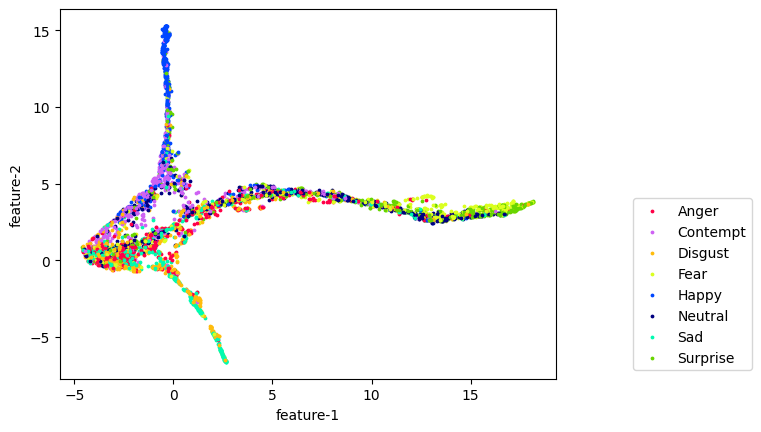

In [16]:
tokens, labels = CLS_tokens(model,
                            feature_extractor,
                            val_label_dataset,
                            device)
plot_tokens(tokens, labels, 10, id2label)

100%|██████████| 4000/4000 [06:12<00:00, 10.74it/s]


(4000, 2)
(4000,)


/tmp/ipykernel_1935142/4046857062.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


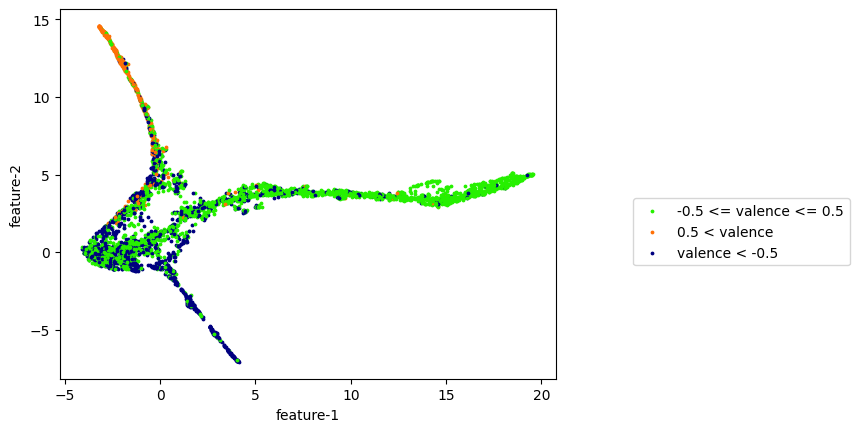

In [17]:
tokens, labels = CLS_tokens(model,
                            feature_extractor,
                            val_valence_dataset,
                            device)
plot_tokens(tokens, labels, 10, labeled_valence)